# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## We will go fast today! Hold on to your hat..

In [32]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.items import Item 
#from loaders import ItemLoader
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.loaders import ItemLoader
#from testing import Tester
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.testing import Tester

In [33]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [34]:
openai = OpenAI()

In [35]:
# Load in the test pickle file
# See the section "Back to the PKL files" in the day2.0 notebook
# for instructions on obtaining this test.pkl file

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [36]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [37]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [38]:
DB = "products_vectorstore"

In [39]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [40]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [41]:
description(test[0])

'Kastar Battery and Charger Replacement for Sony\nBullet Point 1 Kastar Mini Rapid A/C Charger Features a Fold-out US Plug, Worldwide Input Voltage, Car Charging Adapter, and European Plug. Bullet Point 2 Kastar Battery Utra-high Capacity. Use high quality Japanese Cells for longer battery life with no Memory Effect. Bullet Point 3 Charge indication Green lights for standby, Red is for charging and with automatic constant current control prevents battery from overcharging, short circuit, and electronic shock. Bullet Point 4 All Items 100% decoded and 100% Compatible with the Original Camera, Battery, and Power Accessories. Bullet Point 5 All Items Include 30-day Money Back and 3-YEAR Manufacturer Warranty. Description Details Package Includes 1 x Battery 1 x Travel'

In [42]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [43]:
def vector(item):
    return model.encode([description(item)])

In [44]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [45]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Sony a5100 Mirrorless Digital Camera with 3-Inch Flip Up LCD (Black) (Renewed)
Sony a5100 Interchangeable Lens Camera with Lens, Black. Exposure Modes- AUTO (iAUTO, Superior Auto), Programmed AE (P), Aperture priority (A), Shutter-speed priority (S), Manual (M), Scene Selection, Sweep Panorama, Movie Ultra-fast auto focus with 179 AF points and 6Fps Capture life in high resolution with 24MP APS-C sensor.Lens compatibility Sony E-mount lenses Instant sharing via smartphone with Wi-Fi and NFC1 Record Full HD video3 up to 50MB/s Contains- Rechargeable Battery AC Charger Lens cap Shoulder strap Micro USB cable. BIONZ X engine for superb detail and noise reduction

Price is $699.00


In [46]:
documents, prices = find_similars(test[1])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Digital Hygrometer,Aorious Thermometer Humidity Monitor Indoor Temperature Gauge Humidity Meter Smart Timer with Touchscreen and Backlight
Features Touch screen LCD display and LED Backlit 4 Digits time display Hour,Minute 12/24 Hour format selectable Smart Comfort level in color display MAX/MIX temperature and humidityy data Alarm and Snooze minutes snooze alarming For indoor temperature,humidity and time display Temperature data display Resolution 0.1 ℃,Range from 0℃ /32℉ -50℃ /122℉ Humidity data display Resolution form Temperature display in ℉/℃ Specification Dimension 3.3 x 3.3 x 0.8 in Battery Required 2 x AAA / 1.5V (Not included) Package Content 1 x Digital
Price is $14.99

Potentially related product:
Preciser(TM) Multi-function Indoor Room LCD Electronic Temperature Humidity Meter Digital Thermometer Hygrometer Weather Station Alarm Clock
Fea

In [48]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nDigital Hygrometer,Aorious Thermometer Humidity Monitor Indoor Temperature Gauge Humidity Meter Smart Timer with Touchscreen and Backlight\nFeatures Touch screen LCD display and LED Backlit 4 Digits time display Hour,Minute 12/24 Hour format selectable Smart Comfort level in color display MAX/MIX temperature and humidityy data Alarm and Snooze minutes snooze alarming For indoor temperature,humidity and time display Temperature data display Resolution 0.1 ℃,Range from 0℃ /32℉ -50℃ /122℉ Humidity data display Resolution form Temperature display in ℉/℃ Specification Dimension 3.3 x 3.3 x 0.8 in Battery Required 2 x AAA / 1.5V (Not included) Package Content 1 x Digital\nPrice is $14.99\n\nPotentially related product:\n

In [49]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [50]:
get_price("The price for this is $99.99")

99.99

In [51]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [52]:
gpt_4o_mini_rag(test[1])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

399.99

In [53]:
test[1].price

699.0

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1: Guess: $45.99 Truth: $13.99 Error: $32.00 SLE: 1.31 Item: Kastar NP-FH50 Battery (1-Pack) and Char...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2: Guess: $399.99 Truth: $699.00 Error: $299.01 SLE: 0.31 Item: Sony a5100 16-50mm Mirrorless Digital Ca...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

3: Guess: $69.99 Truth: $69.99 Error: $0.00 SLE: 0.00 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

4: Guess: $49.00 Truth: $64.95 Error: $15.95 SLE: 0.08 Item: Fotodiox Pro Lens Mount Adapter - Bronic...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

5: Guess: $79.99 Truth: $110.90 Error: $30.91 SLE: 0.10 Item: FOSA 10" Car Digital TV, ATSC Portable H...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

6: Guess: $8.99 Truth: $5.99 Error: $3.00 SLE: 0.13 Item: Pineapple Vinyl Decal - Laptop, Decor, W...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

7: Guess: $499.00 Truth: $529.00 Error: $30.00 SLE: 0.00 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

8: Guess: $18.99 Truth: $14.98 Error: $4.01 SLE: 0.05 Item: UpBright New Global 5V AC/DC Adapter Com...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

9: Guess: $113.99 Truth: $113.99 Error: $0.00 SLE: 0.00 Item: OEM Electrolux Dryer Lint Filter Screen ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

10: Guess: $749.99 Truth: $829.99 Error: $80.00 SLE: 0.01 Item: HP 2023 Newest Pavilion Desktop, AMD Ryz...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

11: Guess: $29.99 Truth: $47.99 Error: $18.00 SLE: 0.21 Item: USB Type-C Adapter 10-in-1 Aluminum Body...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

12: Guess: $79.99 Truth: $42.99 Error: $37.00 SLE: 0.37 Item: OontZ Ultra Bluetooth Speaker with Carry...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

13: Guess: $59.99 Truth: $32.99 Error: $27.00 SLE: 0.34 Item: CMS 16GB (2X8GB) DDR3 10600 1333MHZ Non ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

14: Guess: $109.95 Truth: $124.99 Error: $15.04 SLE: 0.02 Item: Gariz Genuine Leather XS-CHDFBR Camera M...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

15: Guess: $73.00 Truth: $73.00 Error: $0.00 SLE: 0.00 Item: Samsung DA63-01262B Guard-Ref Mid


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

16: Guess: $95.00 Truth: $95.31 Error: $0.31 SLE: 0.00 Item: Alphamax Haganai: I Don't Have Many Frie...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

17: Guess: $39.99 Truth: $36.95 Error: $3.04 SLE: 0.01 Item: WORLDS BEST CABLES 0.5 Foot RCA Cable Pa...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

18: Guess: $209.99 Truth: $295.69 Error: $85.70 SLE: 0.12 Item: Poly Voyager Free 60+ UC True Wireless E...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

19: Guess: $149.99 Truth: $168.41 Error: $18.42 SLE: 0.01 Item: Visionis FPC-5008 Two Door Access Contro...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

20: Guess: $49.99 Truth: $178.86 Error: $128.87 SLE: 1.59 Item: EVGA 512-P3-N800-TR e-GeForce 8800 GT 51...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

21: Guess: $149.99 Truth: $85.90 Error: $64.09 SLE: 0.31 Item: AVUE 3G-SDI/HD-SDI/SDI 1 to 2 Distributi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

22: Guess: $23.99 Truth: $10.89 Error: $13.10 SLE: 0.55 Item: UpBright 12V AC/DC Adapter Compatible wi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

23: Guess: $119.99 Truth: $189.99 Error: $70.00 SLE: 0.21 Item: GOOZEEZOO 1.10D Malachite DSP SDR Radio ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

24: Guess: $299.99 Truth: $239.00 Error: $60.99 SLE: 0.05 Item: ASUS E14 (L406NA-WH02) Laptop, 14" HD Di...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

25: Guess: $179.99 Truth: $89.99 Error: $90.00 SLE: 0.47 Item: Battery Charger 36V 13A for EZGO EZ-GO T...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

26: Guess: $199.00 Truth: $175.87 Error: $23.13 SLE: 0.02 Item: Garmin GT23M-TM Transducer, Black


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

27: Guess: $99.95 Truth: $48.71 Error: $51.24 SLE: 0.50 Item: Celestron R/A Single Axis Motor Drive fo...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

28: Guess: $29.99 Truth: $25.38 Error: $4.61 SLE: 0.03 Item: Kemo M032S 12 Watt Universal Mono Plug a...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

29: Guess: $34.99 Truth: $34.95 Error: $0.04 SLE: 0.00 Item: Arch Memory Replacement for Dell SNPMKYF...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

30: Guess: $601.14 Truth: $313.89 Error: $287.25 SLE: 0.42 Item: GENUINE Frigidaire 316456224 Glass Cook ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

31: Guess: $199.99 Truth: $240.00 Error: $40.01 SLE: 0.03 Item: Vertical Cable Cat6, UTP, Gel Filled (Fl...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

32: Guess: $99.99 Truth: $151.20 Error: $51.21 SLE: 0.17 Item: Headsets ONLY-GN9350E


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

33: Guess: $34.99 Truth: $33.95 Error: $1.04 SLE: 0.00 Item: SparkFun Pro RF - LoRa, 915MHz (SAMD21) ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

34: Guess: $119.99 Truth: $69.99 Error: $50.00 SLE: 0.28 Item: Telescope for Adults & Kids - NACATIN 70...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

35: Guess: $49.99 Truth: $44.99 Error: $5.00 SLE: 0.01 Item: Samsung DVD-P401 Progressive-Scan DVD Pl...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

36: Guess: $14.99 Truth: $48.99 Error: $34.00 SLE: 1.30 Item: FOINNEX HDMI to Mini Displayport Adapter...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

37: Guess: $449.00 Truth: $162.20 Error: $286.80 SLE: 1.03 Item: WatchGuard Firebox T10 with 1YR Standard...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

38: Guess: $29.99 Truth: $25.99 Error: $4.00 SLE: 0.02 Item: i-Blason Case for New iPad Pro 11 Inch C...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

39: Guess: $399.00 Truth: $770.00 Error: $371.00 SLE: 0.43 Item: Awoco 72" Elegant 2 Speeds 1800CFM Comme...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

40: Guess: $329.99 Truth: $357.95 Error: $27.96 SLE: 0.01 Item: Dell Optiplex 7060 Mini Tower | Intel Qu...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

41: Guess: $114.99 Truth: $129.99 Error: $15.00 SLE: 0.01 Item: AIYIMA A08 PRO TPA3255 Power Amplifier B...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

42: Guess: $49.99 Truth: $64.36 Error: $14.37 SLE: 0.06 Item: ACER ASPIRE 7741Z-4643 Laptop Screen 17....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

43: Guess: $39.99 Truth: $35.99 Error: $4.00 SLE: 0.01 Item: Dentsing PI06 Compatible Laptop Battery ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

44: Guess: $45.99 Truth: $82.99 Error: $37.00 SLE: 0.34 Item: Brady LAT-40-799-1 0.5" Width x 0.750" H...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

45: Guess: $19.99 Truth: $16.99 Error: $3.00 SLE: 0.02 Item: USA Gear DSLR Camera Case Sleeve with Ac...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

46: Guess: $14.99 Truth: $11.85 Error: $3.14 SLE: 0.05 Item: EDO Tech Mini USB AC Adapter Wall Charge...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

47: Guess: $29.99 Truth: $76.99 Error: $47.00 SLE: 0.85 Item: Vemico EN-EL25 Battery 2-Pack 1350mAh an...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

48: Guess: $39.99 Truth: $35.00 Error: $4.99 SLE: 0.02 Item: 5A-75B Colorlight Best Price LED Screen ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

49: Guess: $209.99 Truth: $143.11 Error: $66.88 SLE: 0.15 Item: ASUS Radeon RX 580 O4G Dual-Fan OC Editi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

50: Guess: $75.00 Truth: $75.99 Error: $0.99 SLE: 0.00 Item: Tiffen 67HTCGND6 67MM Digital HT Grad ND...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

51: Guess: $1.00 Truth: $899.00 Error: $898.00 SLE: 37.32 Item: Voigtlander Macro APO-LANTHAR 110mm F/2....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

52: Guess: $94.99 Truth: $54.97 Error: $40.02 SLE: 0.29 Item: VIZIO V-Series 2.0 Compact Home Theater ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

53: Guess: $29.99 Truth: $24.36 Error: $5.63 SLE: 0.04 Item: DIY Smartphone Projector 2.0, Mini DIY H...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

54: Guess: $12.99 Truth: $16.49 Error: $3.50 SLE: 0.05 Item: USB Extension, Canjoy 3 Pack 6.6ft USB 3...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

55: Guess: $149.00 Truth: $145.00 Error: $4.00 SLE: 0.00 Item: Tiltaing Lightweight Kit Compatible with...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

56: Guess: $99.00 Truth: $129.99 Error: $30.99 SLE: 0.07 Item: Wireless HDMI Extender Kit HDMI Wireless...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

57: Guess: $179.00 Truth: $138.99 Error: $40.01 SLE: 0.06 Item: Nitze 15mm Follow Focus Kit with 3 Rever...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

58: Guess: $399.95 Truth: $359.99 Error: $39.96 SLE: 0.01 Item: Hifonics BXX4000.1D Brutus Class D 4000W...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

59: Guess: $12.99 Truth: $17.99 Error: $5.00 SLE: 0.09 Item: SIMTOP Electronic Organizer, Travel cabl...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

60: Guess: $169.00 Truth: $209.00 Error: $40.00 SLE: 0.04 Item: Audio-Technica ATH-CKR7TW True Wireless ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

61: Guess: $39.99 Truth: $49.95 Error: $9.96 SLE: 0.05 Item: Large Flat Screen TV/LED / HDTV Vinyl Pa...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

62: Guess: $15.99 Truth: $6.88 Error: $9.11 SLE: 0.59 Item: Zahara DC in Power Jack Charging Port Pl...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

63: Guess: $129.99 Truth: $129.99 Error: $0.00 SLE: 0.00 Item: Nictemaw Washing Machine 17.6lbs Portalb...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

64: Guess: $95.00 Truth: $199.98 Error: $104.98 SLE: 0.55 Item: TM-U220B, Impact, two-color printing, 6 ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

65: Guess: $29.99 Truth: $23.56 Error: $6.43 SLE: 0.05 Item: GOTOTOP Car Siren Horn Speaker, Loud Hor...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

66: Guess: $49.99 Truth: $46.99 Error: $3.00 SLE: 0.00 Item: ZLiT for Insta360 X3 Protective Cage,Alu...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

67: Guess: $41.95 Truth: $41.95 Error: $0.00 SLE: 0.00 Item: pp-Code WiFi Temperature and Humidity Se...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

68: Guess: $9.99 Truth: $7.99 Error: $2.00 SLE: 0.04 Item: Portable Square Earphone Carrying Case M...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

69: Guess: $109.99 Truth: $42.99 Error: $67.00 SLE: 0.86 Item: RECOIL RCK0 True 0 Gauge Complete CCA Am...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

70: Guess: $15.99 Truth: $7.99 Error: $8.00 SLE: 0.41 Item: WANBY Camera Soft Cotton Hand Wrist Stra...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

71: Guess: $399.99 Truth: $666.05 Error: $266.06 SLE: 0.26 Item: Lenovo ThinkPad W541 Mobile Workstation ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

72: Guess: $449.00 Truth: $597.00 Error: $148.00 SLE: 0.08 Item: Lenovo ThinkBook 15 IIL Core i5-1035G1 8...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

73: Guess: $99.99 Truth: $145.99 Error: $46.00 SLE: 0.14 Item: Liene 4x6'' Photo Printer Bundle (60 pcs...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

74: Guess: $29.99 Truth: $22.50 Error: $7.49 SLE: 0.08 Item: PWR+ Laptop Charger for Asus Vivobook Go...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

75: Guess: $149.99 Truth: $43.39 Error: $106.60 SLE: 1.50 Item: POA-LMP LP68 Replacement Projector Lamp ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

76: Guess: $89.99 Truth: $89.99 Error: $0.00 SLE: 0.00 Item: VIVO Black 1,000ft Bulk Cat5e, CCA Ether...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

77: Guess: $19.99 Truth: $19.07 Error: $0.92 SLE: 0.00 Item: Bewinner 10 Inch Universal PU Leather Ke...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

78: Guess: $39.99 Truth: $69.44 Error: $29.45 SLE: 0.29 Item: Logitech LX5 Cordless Optical Mouse


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

79: Guess: $69.99 Truth: $175.99 Error: $106.00 SLE: 0.83 Item: LUCKYLAKER Boat Transducer Fish Finders ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

80: Guess: $95.00 Truth: $24.11 Error: $70.89 SLE: 1.80 Item: Panavise In Dash Mount GMC/Chevy W-Serie...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

81: Guess: $149.99 Truth: $76.10 Error: $73.89 SLE: 0.45 Item: Blaupunkt AMP1904D Universal Car Speaker...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

82: Guess: $149.00 Truth: $199.00 Error: $50.00 SLE: 0.08 Item: Swarovski Optik VPA Variable Phone Adapt...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

83: Guess: $95.99 Truth: $54.00 Error: $41.99 SLE: 0.32 Item: CMS 32GB (4X8GB) DDR3 12800 1600MHz Non ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

84: Guess: $69.99 Truth: $58.99 Error: $11.00 SLE: 0.03 Item: Kodak Professional Ektar Color Negative ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

85: Guess: $36.99 Truth: $26.98 Error: $10.01 SLE: 0.09 Item: SM-T510 Touch Screen Glass Screen Replac...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

86: Guess: $39.00 Truth: $52.00 Error: $13.00 SLE: 0.08 Item: Apple 35W Dual USB-C Port Compact Power ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

87: Guess: $19.99 Truth: $31.34 Error: $11.35 SLE: 0.19 Item: ForestGreen Envelop Pouch Case for iPad ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

88: Guess: $59.00 Truth: $69.99 Error: $10.99 SLE: 0.03 Item: Inateck Surface Pro 7 Keyboard, 7-Color ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

89: Guess: $219.99 Truth: $209.14 Error: $10.85 SLE: 0.00 Item: Dell Optiplex 990 MiniTower PC - Intel C...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

90: Guess: $24.99 Truth: $69.16 Error: $44.17 SLE: 0.99 Item: Western Digital My Passport Essential 16...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

91: Guess: $59.99 Truth: $175.95 Error: $115.96 SLE: 1.13 Item: Vis Viva Raspberry Pi 4 Model B Starter ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

92: Guess: $34.00 Truth: $43.99 Error: $9.99 SLE: 0.06 Item: 2x Pack - KNB-35L Battery Replacement (2...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

93: Guess: $45.99 Truth: $118.95 Error: $72.96 SLE: 0.88 Item: Starcraft Protoss Pylon Desktop Power St...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

94: Guess: $159.99 Truth: $220.78 Error: $60.79 SLE: 0.10 Item: ASUS TUF Gaming GeForce GTX 1650 Dual Fa...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

95: Guess: $329.00 Truth: $329.00 Error: $0.00 SLE: 0.00 Item: BornTech Electric Cooler Portable Refrig...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

96: Guess: $79.99 Truth: $79.13 Error: $0.86 SLE: 0.00 Item: Sony BDP-S350 1080p Blu-Ray Disc Player


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

97: Guess: $69.99 Truth: $97.00 Error: $27.01 SLE: 0.10 Item: Promaster Cityscape 150 Courier Bag - Ha...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

98: Guess: $24.99 Truth: $46.95 Error: $21.96 SLE: 0.38 Item: Sescom DSLR-550D-HOCF A/V Out Headphone ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

99: Guess: $54.80 Truth: $54.80 Error: $0.00 SLE: 0.00 Item: Frigidaire 316032411 Oven Thermostat


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100: Guess: $29.99 Truth: $18.59 Error: $11.40 SLE: 0.21 Item: 65W 45W USB Type C Laptop Charger for Le...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

101: Guess: $109.95 Truth: $118.88 Error: $8.93 SLE: 0.01 Item: Xuerebs EF-EOS R ND Lens Adapter with ND...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

102: Guess: $249.00 Truth: $129.00 Error: $120.00 SLE: 0.43 Item: Godox TT685IIC 1/8000s HSS GN Speedlite ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

103: Guess: $39.99 Truth: $25.88 Error: $14.11 SLE: 0.18 Item: AC Charger Fit for Dell XPS 15 7590 9530...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

104: Guess: $19.99 Truth: $24.99 Error: $5.00 SLE: 0.05 Item: Landalanya Replacement New CPU +GPU Cool...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

105: Guess: $89.99 Truth: $139.95 Error: $49.96 SLE: 0.19 Item: Canon Powershot SX110IS 9MP Digital Came...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

106: Guess: $49.99 Truth: $169.99 Error: $120.00 SLE: 1.46 Item: for Toyota Tacoma 2005-2014 Tailgate Han...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

107: Guess: $59.99 Truth: $75.00 Error: $15.01 SLE: 0.05 Item: MikroTik hAP ac2 RBD52G-5HacD2HnD-TC Dua...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

108: Guess: $69.99 Truth: $70.19 Error: $0.20 SLE: 0.00 Item: AU Optronics New 17.3" LED Laptop Screen...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

109: Guess: $114.99 Truth: $199.95 Error: $84.96 SLE: 0.30 Item: Fujifilm INSTAX Wide 300 Instant Camera ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

110: Guess: $169.99 Truth: $235.99 Error: $66.00 SLE: 0.11 Item: Eonon Apple CarPlay & Android Auto Car S...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

111: Guess: $22.99 Truth: $9.99 Error: $13.00 SLE: 0.61 Item: YUSTDA (10Ft Extra Long) New AC Adapter ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

112: Guess: $39.99 Truth: $42.99 Error: $3.00 SLE: 0.00 Item: Leather Laptop Tote Bag Womens Professio...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

113: Guess: $449.00 Truth: $359.00 Error: $90.00 SLE: 0.05 Item: TOKINA ATX-m 56mm F1.4 X Mount Special E...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

114: Guess: $89.99 Truth: $31.99 Error: $58.00 SLE: 1.03 Item: Sony KDF-60X5955 TV Assembly Cage with P...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

115: Guess: $249.99 Truth: $299.00 Error: $49.01 SLE: 0.03 Item: Lenovo Monitor, L24q 23.8-Inch Monitor, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

116: Guess: $45.00 Truth: $79.99 Error: $34.99 SLE: 0.32 Item: Canis LATRANS PVS 14 Mount Night Vision ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

117: Guess: $45.99 Truth: $29.99 Error: $16.00 SLE: 0.17 Item: KMC 6-Outlet Surge Protector Power Strip...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

118: Guess: $99.99 Truth: $56.99 Error: $43.00 SLE: 0.31 Item: Amcrest 5MP Turret POE Camera, UltraHD O...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

119: Guess: $299.99 Truth: $271.11 Error: $28.88 SLE: 0.01 Item: KLH Albany II 2-Way Bookshelf Speakers f...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

120: Guess: $149.95 Truth: $135.58 Error: $14.37 SLE: 0.01 Item: Thule TPCS-101 Perspektiv Perspektiv Com...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

121: Guess: $69.99 Truth: $99.02 Error: $29.03 SLE: 0.12 Item: NEEWER Air Cushioned Aluminum Light Stan...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

122: Guess: $9.99 Truth: $5.49 Error: $4.50 SLE: 0.28 Item: Cable Matters 6-Pack BNC Female to Femal...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

123: Guess: $14.99 Truth: $15.99 Error: $1.00 SLE: 0.00 Item: Halloween Party Decorations Black Bat Fr...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

124: Guess: $29.99 Truth: $12.88 Error: $17.11 SLE: 0.65 Item: Sima SIP-3 Ultimate International Travel...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

125: Guess: $109.99 Truth: $261.87 Error: $151.88 SLE: 0.74 Item: Pyle PLPW15D 15" 8000W Car Subwoofer Aud...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

126: Guess: $549.99 Truth: $580.00 Error: $30.01 SLE: 0.00 Item: Dell XPS13-1000sLV 13-Inch Ultrabook (1....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

127: Guess: $12.99 Truth: $11.99 Error: $1.00 SLE: 0.01 Item: Manleno Compatible with Airpods 3 Case C...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

128: Guess: $89.99 Truth: $109.99 Error: $20.00 SLE: 0.04 Item: Digital Photo Frame WiFi 10 Inch Touch S...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

129: Guess: $40.56 Truth: $40.60 Error: $0.04 SLE: 0.00 Item: General Electric WR17X11459 Cup Drive Ic...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

130: Guess: $9.99 Truth: $4.99 Error: $5.00 SLE: 0.37 Item: UpBright USB Cable for HP PSC 380 500 70...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

131: Guess: $39.99 Truth: $59.99 Error: $20.00 SLE: 0.16 Item: HSM shredstar X5 Cross Cut Shredder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

132: Guess: $24.99 Truth: $11.98 Error: $13.01 SLE: 0.48 Item: Dudaacvt 7x5FT Kindergarten Graduation B...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

133: Guess: $29.99 Truth: $30.95 Error: $0.96 SLE: 0.00 Item: Cell Phone Headset with Microphone Noise...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

134: Guess: $79.99 Truth: $179.99 Error: $100.00 SLE: 0.65 Item: FIBBR DisplayPort to DisplayPort Cable, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

135: Guess: $89.00 Truth: $62.99 Error: $26.01 SLE: 0.12 Item: Mcoplus LED-520 Video Lighting Kits, Hig...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

136: Guess: $299.99 Truth: $157.00 Error: $142.99 SLE: 0.42 Item: HP ProBook 640 G2 Laptop, 14 Display, In...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

137: Guess: $12.95 Truth: $14.95 Error: $2.00 SLE: 0.02 Item: HQRP Battery Compatible with GolfBuddy L...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

138: Guess: $99.99 Truth: $94.99 Error: $5.00 SLE: 0.00 Item: BaseQi NinjaDrive Aluminum 256GB Storage...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

139: Guess: $114.99 Truth: $110.16 Error: $4.83 SLE: 0.00 Item: Legacy LXR7A 3Way Stereo Electronic Cros...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

140: Guess: $39.99 Truth: $78.99 Error: $39.00 SLE: 0.45 Item: Sony DVP-NS70H HDMI Single Disc DVD Play...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

141: Guess: $64.99 Truth: $150.00 Error: $85.01 SLE: 0.69 Item: B+W 72mm Slim-Line Circular Polarizer wi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

142: Guess: $24.99 Truth: $24.89 Error: $0.10 SLE: 0.00 Item: 2022 Bluetooth 5.3 FM Transmitter for Ca...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

143: Guess: $21.99 Truth: $15.99 Error: $6.00 SLE: 0.09 Item: YongFoto 6x4ft Spring Scenery Backdrop M...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

144: Guess: $39.99 Truth: $41.74 Error: $1.75 SLE: 0.00 Item: Dentsing F7HVR 58Wh Battery for DELL Ins...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

145: Guess: $99.99 Truth: $100.03 Error: $0.04 SLE: 0.00 Item: A-Tech 32GB Kit 4x8GB Memory Ram For DEL...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

146: Guess: $5.99 Truth: $3.99 Error: $2.00 SLE: 0.11 Item: Leyland Designs Rezero Rem Waifu Sticker...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

147: Guess: $150.00 Truth: $289.98 Error: $139.98 SLE: 0.43 Item: Olympus Xa Film Camera with A16 Electron...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

148: Guess: $169.99 Truth: $118.99 Error: $51.00 SLE: 0.13 Item: AUTO-VOX Solar 1 Wireless Backup Camera ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

149: Guess: $99.99 Truth: $114.99 Error: $15.00 SLE: 0.02 Item: WD 2TB My Passport SSD Portable External...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

150: Guess: $89.14 Truth: $89.14 Error: $0.00 SLE: 0.00 Item: GLOB PRO SOLUTIONS WPW10415587 Washer Pr...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

151: Guess: $49.99 Truth: $54.99 Error: $5.00 SLE: 0.01 Item: UGREEN USB C Hub 9 in 1 USB Type C HDMI ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

152: Guess: $10.50 Truth: $58.93 Error: $48.43 SLE: 2.73 Item: UV Polyethylene Spiral Wrap Cable Harnes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

153: Guess: $39.99 Truth: $217.00 Error: $177.01 SLE: 2.79 Item: 50 4GB Flash Drive - Bulk Pack - USB 2.0...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

154: Guess: $89.99 Truth: $199.99 Error: $110.00 SLE: 0.63 Item: RCA Voyager Pro 7 16GB Tablet with Keybo...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

155: Guess: $114.99 Truth: $128.89 Error: $13.90 SLE: 0.01 Item: McKlein, R Series, Walton, Tech-Lite Bal...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

156: Guess: $549.99 Truth: $312.99 Error: $237.00 SLE: 0.32 Item: HP EliteBook x360 1030 G2 Notebook 2-in-...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

157: Guess: $24.99 Truth: $10.99 Error: $14.00 SLE: 0.60 Item: Padarsey Keyboard with Frame Compatible ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

158: Guess: $39.99 Truth: $53.64 Error: $13.65 SLE: 0.08 Item: BULGIN PX0441/2M00 Cable Assy, USB IP68,...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

159: Guess: $19.99 Truth: $29.99 Error: $10.00 SLE: 0.15 Item: UFBOSS Powered 5-Port Mini USB 3.0 HUB a...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

160: Guess: $19.99 Truth: $18.99 Error: $1.00 SLE: 0.00 Item: TKDY 24V 2.5A Power Supply Cord, DC 24V ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

161: Guess: $39.99 Truth: $37.99 Error: $2.00 SLE: 0.00 Item: VASCHY Laptop Backpack, Vintage Water Re...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

162: Guess: $29.00 Truth: $22.56 Error: $6.44 SLE: 0.06 Item: LDG Electronics Y-Acc One-Touch-Tune Cab...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

163: Guess: $16.99 Truth: $14.99 Error: $2.00 SLE: 0.01 Item: Divufus Case for iPad 10th Generation 20...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

164: Guess: $12.99 Truth: $7.99 Error: $5.00 SLE: 0.20 Item: HDMI Cable, HDMI to HDMI Cable 6FT HDMI ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

165: Guess: $139.99 Truth: $165.90 Error: $25.91 SLE: 0.03 Item: LimoStudio Photo Shooting Kit with Backg...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

166: Guess: $29.99 Truth: $42.98 Error: $12.99 SLE: 0.12 Item: Maxtek 2 Pack 4.5 hours BP-827 Li-Ion Re...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

167: Guess: $229.99 Truth: $199.99 Error: $30.00 SLE: 0.02 Item: Ikan E-Image 2 Stage Aluminum Video Trip...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

168: Guess: $39.99 Truth: $36.95 Error: $3.04 SLE: 0.01 Item: Samsung ram Memory 16GB kit (2 x 8GB) DD...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

169: Guess: $399.99 Truth: $399.00 Error: $0.99 SLE: 0.00 Item: Dell Optiplex 9020 Small Form Factor Des...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

170: Guess: $29.99 Truth: $42.50 Error: $12.51 SLE: 0.11 Item: U-810 USB 3.0 Hub with Gigabit Ethernet


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

171: Guess: $199.99 Truth: $199.99 Error: $0.00 SLE: 0.00 Item: DS18 SXE-2500.1D/RD Car Amplifier Class ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

172: Guess: $29.99 Truth: $17.99 Error: $12.00 SLE: 0.24 Item: KIQ Guardian Series for Apple iPad 6th G...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

173: Guess: $119.99 Truth: $95.00 Error: $24.99 SLE: 0.05 Item: HP USB-C Dock G5 (Refurbished)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

174: Guess: $95.99 Truth: $42.69 Error: $53.30 SLE: 0.64 Item: Extreme Battery XTAZ10S Powersports Repl...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

175: Guess: $799.00 Truth: $694.50 Error: $104.50 SLE: 0.02 Item: Samyang SYXP14-C XP 14mm f/2.4 High Spee...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

176: Guess: $24.99 Truth: $22.47 Error: $2.52 SLE: 0.01 Item: Intel Centrino Advanced-N 6235 6235ANHMW...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

177: Guess: $29.99 Truth: $27.00 Error: $2.99 SLE: 0.01 Item: CMS 8GB (2X4GB) DDR3 10600 1333MHZ Non E...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

178: Guess: $24.99 Truth: $37.00 Error: $12.01 SLE: 0.14 Item: Nikon AF-S Nikkor 35mm f/1.8G DX Pro Dig...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

179: Guess: $249.00 Truth: $39.90 Error: $209.10 SLE: 3.28 Item: Hoya SOLAS IRND 2.7 62mm Infrared Neutra...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

180: Guess: $199.99 Truth: $233.73 Error: $33.74 SLE: 0.02 Item: Direct Burial/Outdoor Rated Cat6 Black E...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

181: Guess: $499.99 Truth: $325.94 Error: $174.05 SLE: 0.18 Item: LG 24” 24CK550Z-BP FHD (1920x1080) IPS Z...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

182: Guess: $19.99 Truth: $1.99 Error: $18.00 SLE: 3.80 Item: FitSand Hard Case Compatible for Valoin ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

183: Guess: $109.99 Truth: $119.95 Error: $9.96 SLE: 0.01 Item: Razer Nommo Chroma - Computer Speakers, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

184: Guess: $39.99 Truth: $38.00 Error: $1.99 SLE: 0.00 Item: Auto Wayfeng WF® IR Control 4 Cameras Vi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

185: Guess: $749.99 Truth: $629.95 Error: $120.04 SLE: 0.03 Item: Sigma 105mm f/2.8 EX DG OS HSM Macro Len...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

186: Guess: $149.00 Truth: $199.00 Error: $50.00 SLE: 0.08 Item: Saregama Carvaan 2.0 Portable Digital Mu...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

187: Guess: $49.95 Truth: $179.99 Error: $130.04 SLE: 1.61 Item: Greenlee 468 Wiremap Tester


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

188: Guess: $399.99 Truth: $699.99 Error: $300.00 SLE: 0.31 Item: EVGA GeForce GTX 1080 FTW GAMING ACX 3.0...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

189: Guess: $45.99 Truth: $43.99 Error: $2.00 SLE: 0.00 Item: Kastar Charger + 3 Battery for Hewlett P...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

190: Guess: $12.99 Truth: $4.99 Error: $8.00 SLE: 0.72 Item: 100 Pcs no-Repeating Stickers for Water ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

191: Guess: $29.95 Truth: $35.96 Error: $6.01 SLE: 0.03 Item: 3ft. HD PTTL Off-Camera Cord for Pentax ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

192: Guess: $249.99 Truth: $269.00 Error: $19.01 SLE: 0.01 Item: 5G WiFi 8 Core 1280 * 720 Resolution Car...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

193: Guess: $29.99 Truth: $22.29 Error: $7.70 SLE: 0.08 Item: Pyle Water Resistant Marine Stereo Cover...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

194: Guess: $289.99 Truth: $185.00 Error: $104.99 SLE: 0.20 Item: Lenovo 14w Laptop Gen 2, 14" HD (1366X76...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

195: Guess: $89.99 Truth: $64.99 Error: $25.00 SLE: 0.10 Item: SoundXtreme ST-X6400BT MP5 7" digital TF...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

196: Guess: $9.99 Truth: $0.69 Error: $9.30 SLE: 3.51 Item: Yxflzer USB 2.0 Type A Female to Micro U...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

197: Guess: $99.99 Truth: $269.95 Error: $169.96 SLE: 0.97 Item: Sharp GXBT9 Portable Bluetooth Boom Box ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

198: Guess: $109.99 Truth: $58.99 Error: $51.00 SLE: 0.38 Item: Polk Audio DB402 DB+ Series 4" Coaxial S...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

199: Guess: $49.99 Truth: $64.52 Error: $14.53 SLE: 0.06 Item: DJI Phantom 4 - Part 9 100W Battery Char...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

200: Guess: $199.99 Truth: $169.00 Error: $30.99 SLE: 0.03 Item: Feniex Industries C-4014 Storm Pro 100W ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

201: Guess: $28.99 Truth: $25.01 Error: $3.98 SLE: 0.02 Item: UpBright 25V AC/DC Adapter Compatible wi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

202: Guess: $49.99 Truth: $55.77 Error: $5.78 SLE: 0.01 Item: BOWEIRUI AA-PBTN2TP Laptop Battery Repla...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

203: Guess: $39.99 Truth: $34.90 Error: $5.09 SLE: 0.02 Item: Verbatim 128GB Vx460 External SSD USB 3....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

204: Guess: $249.99 Truth: $299.95 Error: $49.96 SLE: 0.03 Item: Kicker 46CXA4001 Car Audio Class D Mono ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

205: Guess: $499.00 Truth: $279.00 Error: $220.00 SLE: 0.34 Item: Definitive Technology Dt Series Dt8Lcr i...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

206: Guess: $329.00 Truth: $172.12 Error: $156.88 SLE: 0.42 Item: Lenovo 14" FHD Laptop - AMD A6-9220C Dua...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

207: Guess: $29.99 Truth: $38.19 Error: $8.20 SLE: 0.06 Item: SureCall J-Bar Outdoor Antenna Mounting ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

208: Guess: $599.99 Truth: $899.00 Error: $299.01 SLE: 0.16 Item: 2020 HUION Kamvas Pro 24 Drawing Monitor...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

209: Guess: $99.00 Truth: $78.95 Error: $20.05 SLE: 0.05 Item: RYOBI 18V ONE+ Bluetooth Speaker (Tool-O...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

210: Guess: $109.99 Truth: $164.49 Error: $54.50 SLE: 0.16 Item: MikroTik PowerBox Pro Router, 5 Gigabit ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

211: Guess: $19.99 Truth: $14.90 Error: $5.09 SLE: 0.08 Item: Geekria QuickFit Replacement Ear Pads fo...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

212: Guess: $149.99 Truth: $148.02 Error: $1.97 SLE: 0.00 Item: ASUS P6T Deluxe V2 Desktop Board


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

213: Guess: $499.99 Truth: $349.00 Error: $150.99 SLE: 0.13 Item: Apple iPad Pro (32GB, Wi-Fi, Space Gray)...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

214: Guess: $9.99 Truth: $7.97 Error: $2.02 SLE: 0.04 Item: 3 ft. USB 2.0 A Male to A Male and Mini-...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

215: Guess: $499.99 Truth: $749.99 Error: $250.00 SLE: 0.16 Item: HP 2022 17.3" FHD IPS Display Laptop PC ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

216: Guess: $39.99 Truth: $79.99 Error: $40.00 SLE: 0.46 Item: JB Live 500 BT, Around-Ear Wireless Head...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

217: Guess: $199.00 Truth: $319.99 Error: $120.99 SLE: 0.22 Item: nixplay Smart Digital Picture Frame 15.6...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

218: Guess: $9.99 Truth: $6.99 Error: $3.00 SLE: 0.10 Item: Keenso Multipurpose Car Wiring Harness T...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

219: Guess: $249.99 Truth: $117.27 Error: $132.72 SLE: 0.57 Item: HP 8000 Elite Desktop C2D 3.00 8GB 2TB D...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

220: Guess: $129.99 Truth: $93.04 Error: $36.95 SLE: 0.11 Item: Plantronics - Voyager 5200 UC (Poly) - B...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

221: Guess: $6.99 Truth: $1.60 Error: $5.39 SLE: 1.26 Item: 6ft Cat 5E Non-Booted Unshielded (UTP) E...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

222: Guess: $29.99 Truth: $22.99 Error: $7.00 SLE: 0.07 Item: PWR+ Laptop Power Adapter Charger for HP...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

223: Guess: $24.99 Truth: $14.99 Error: $10.00 SLE: 0.24 Item: Se7enline Compatible with MacBook Air 13...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

224: Guess: $24.99 Truth: $42.09 Error: $17.10 SLE: 0.26 Item: Gadget Guard GEGEAP000013 Black Ice Edit...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

225: Guess: $23.99 Truth: $30.59 Error: $6.60 SLE: 0.05 Item: AN-MR650A AN-MR18BA AN-MR19BA Voice Magi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

226: Guess: $29.99 Truth: $49.00 Error: $19.01 SLE: 0.23 Item: [Intel Thunderbolt 3 Certified 40Gbps Th...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

227: Guess: $89.00 Truth: $52.99 Error: $36.01 SLE: 0.26 Item: DKNKD X8VWF 4XKN5 CJ2K1 Laptop Battery f...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

228: Guess: $169.99 Truth: $144.99 Error: $25.00 SLE: 0.02 Item: Hawke Endurance ED Monocular


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

229: Guess: $299.99 Truth: $359.00 Error: $59.01 SLE: 0.03 Item: Radio for Chevrolet Chevy Cruze Stereo 2...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

230: Guess: $15.99 Truth: $4.98 Error: $11.01 SLE: 1.09 Item: FONVOi AUX Cord for iPhone【Apple MFi Cer...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

231: Guess: $29.99 Truth: $69.95 Error: $39.96 SLE: 0.69 Item: American-Wholesaler Inc. New! - Empty Ma...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

232: Guess: $29.99 Truth: $62.99 Error: $33.00 SLE: 0.53 Item: KENUCO PM DS-1275ZJ Universal Vertical P...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

233: Guess: $39.99 Truth: $84.55 Error: $44.56 SLE: 0.54 Item: Starter Tethering Kit w/TetherPro USB 2....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

234: Guess: $24.99 Truth: $56.59 Error: $31.60 SLE: 0.63 Item: USB 3.0 Data Transfer Cable 6.6FT - HBAV...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

235: Guess: $29.99 Truth: $15.97 Error: $14.02 SLE: 0.36 Item: Battery Replacement for Magellan RoadMat...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

236: Guess: $7.99 Truth: $3.99 Error: $4.00 SLE: 0.35 Item: Leyland Designs Fujiwara Chika Sticker O...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

237: Guess: $53.99 Truth: $53.99 Error: $0.00 SLE: 0.00 Item: everydrop by Whirlpool Ice and Water Ref...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

238: Guess: $59.00 Truth: $30.99 Error: $28.01 SLE: 0.40 Item: ELECOM EX-G Trackball Mouse, Wired, Thum...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

239: Guess: $6.99 Truth: $9.49 Error: $2.50 SLE: 0.07 Item: uxcell Polyolefin 13M Length 2mm Dia Hea...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

240: Guess: $24.99 Truth: $28.95 Error: $3.96 SLE: 0.02 Item: Decalrus - Protective Decal Skin Sticker...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

241: Guess: $120.00 Truth: $550.00 Error: $430.00 SLE: 2.30 Item: Genuine Dell NX380 LCD Screen Dell 15.4"...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

242: Guess: $149.99 Truth: $65.99 Error: $84.00 SLE: 0.66 Item: cjc Ultrasonic Inverter, Electro Fisher ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

243: Guess: $109.99 Truth: $109.99 Error: $0.00 SLE: 0.00 Item: IET Replacement Lamp Assembly with Genui...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

244: Guess: $14.99 Truth: $36.91 Error: $21.92 SLE: 0.75 Item: Replacement Remote Control for NAXA NX55...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

245: Guess: $139.99 Truth: $139.00 Error: $0.99 SLE: 0.00 Item: Samsung DVD-R135 DVD Recorder


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

246: Guess: $59.99 Truth: $79.95 Error: $19.96 SLE: 0.08 Item: Glow Speed Ring Adapter to Fit Profoto M...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

247: Guess: $14.99 Truth: $7.99 Error: $7.00 SLE: 0.33 Item: BingoBuy US Layout Clear Non-Toxic Ultra...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

248: Guess: $29.99 Truth: $76.21 Error: $46.22 SLE: 0.83 Item: E-Z-GO Part Number 614029 Adapter


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

249: Guess: $169.99 Truth: $192.05 Error: $22.06 SLE: 0.01 Item: Anker Docking Station, KVM Switch for a ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

250: Guess: $449.95 Truth: $599.00 Error: $149.05 SLE: 0.08 Item: SeaLife DC1400 Pro 14MP HD Underwater Di...


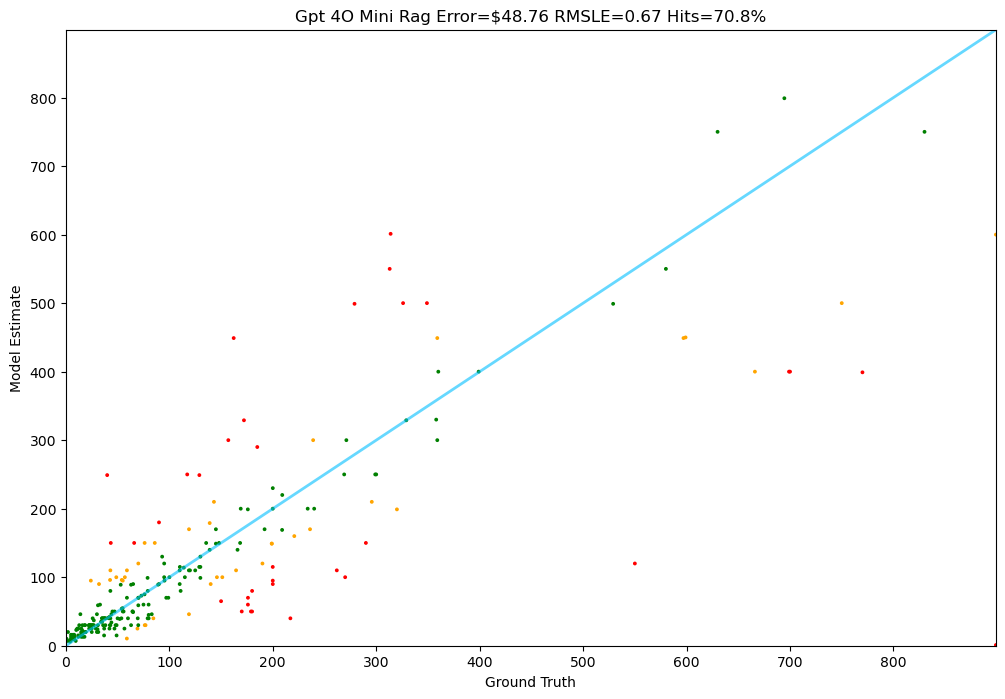

In [54]:
# Plot on results 
Tester.test(gpt_4o_mini_rag, test)

# Josh tries Langchain

In [7]:
with open('train_small.pkl', 'rb') as file:
    train = pickle.load(file)

print(len(train))
print('PROMPT:', train[0].prompt)

def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

print('PROMPT STRIPPED', description(train[0]))

20000
PROMPT: How much does this cost to the nearest dollar?

GOLDEN ICEPURE Replacement for Kenmore 6, WF293, Refrigerator Water Filter 3 PACK
💦𝐂𝐞𝐫𝐭𝐢𝐟𝐢𝐜𝐚𝐭𝐢𝐨𝐧 - The GOLDEN ICEPURE Refrigerator water filter is certified by the NSF/ANSI 42 and meets the requirements of NSF/ANSI/CAN 372. We guarantee the quality, health, and environmental friendliness of our products and services. 💦𝐏𝐞𝐫𝐟𝐨𝐫𝐦𝐚𝐧𝐜𝐞 - Using multi-stage filtration technology and high-grade coconut shell carbon

Price is $23.00
PROMPT STRIPPED GOLDEN ICEPURE Replacement for Kenmore 6, WF293, Refrigerator Water Filter 3 PACK
💦𝐂𝐞𝐫𝐭𝐢𝐟𝐢𝐜𝐚𝐭𝐢𝐨𝐧 - The GOLDEN ICEPURE Refrigerator water filter is certified by the NSF/ANSI 42 and meets the requirements of NSF/ANSI/CAN 372. We guarantee the quality, health, and environmental friendliness of our products and services. 💦𝐏𝐞𝐫𝐟𝐨𝐫𝐦𝐚𝐧𝐜𝐞 - Using multi-stage filtration technology and high-grade coconut shell carbon


In [19]:
import chromadb
from langchain_chroma import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document

# 1. Set up your embedding function
embedding_function = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# 2. Create or connect to a persistent Chroma database
DB_PATH = "./chroma_langchain_db"  # Define your database path

# 3. Initialize your vector store
vector_store = Chroma(
    collection_name="products_langchain",
    embedding_function=embedding_function,
    persist_directory=DB_PATH
)

# 4. Check if you have any documents in the collection
print(f"Collection has {len(vector_store.get()['ids'])} documents")

# 5. If you need to add documents (only do this once to avoid duplicates)
# Convert your test data to Documents and add them
def add_documents_to_vector_store(train):
    documents = []
    for item in train:  # Assuming test is a list of your products
        # Create a proper Document object with the product description
        text = description(item)  # Using your description function
        metadata = {"price": get_price(item.prompt)}  # Using your get_price function
        doc = Document(page_content=text, metadata=metadata)
        documents.append(doc)
    
    # Add the documents to the vector store
    vector_store.add_documents(documents)
    print(f"Added {len(documents)} documents to the vector store")
    # Persist to save to disk
    vector_store.persist()

# JUST NEED TO RUN THE ADD DOCUMENTS FUNCTION ONCE
#add_documents_to_vector_store(train)
print(f"Collection has {len(vector_store.get()['ids'])} documents")

# 6. Now you can search properly
def search_products(query_text):
    results = vector_store.similarity_search(
        query_text,
        k=1
    )
    print(f"Search results for: {query_text}")
    for doc in results:
        print(f"* {doc.page_content}")
        print(f"  Price: ${doc.metadata.get('price', 'N/A')}")
        print()
    return results


# Search by vector
# results_vector = vector_store.similarity_search_by_vector(
#     embedding=embedding_function.embed_query("I love green eggs and ham!"), 
#     k=1
# )

# If you want to search using your test data
# if len(test) > 0:
#     test_query = test[1].prompt
#     print(f"TEST PROMPT: {test_query}")
#     results_test = search_products(test_query)

# Search by text
results_text = search_products("I love green eggs and ham!")

search_products(test[1].prompt)

Collection has 20000 documents
Collection has 20000 documents
Search results for: I love green eggs and ham!
* 2 pcs Portable Egg Storage Eggs Holder Box Container Hiking Outdoor Camping Carrier For 2 Egg Case (Blue)
Description Eating eggs once a day, get weakness away! This eggs box aims at bringing customers convenience and health, and has two bright colors for you to select. We hope deliver warmth and kindness to you via our products. Features 1. It is made of ABS material, it is a brand new non-toxic plastics with better gloss and toughness. 2. Two-eggs capacity is no more no less, keeps you vigorous the whole day. 3. The two-case design can separate egg from egg, which avoids collisions between the eggs and the objects. 4. You can bring it for outdoor picnic, barbecue and other outdoor activities, and enjoy a delicious and happy feast
  Price: $2.0

Search results for: How much does this cost to the nearest dollar?

Sony a5100 Mirrorless Digital Camera with 3-Inch Flip Up LCD (Bl

[Document(id='1b5fffc8-81b4-4beb-8652-fe3398aa2877', metadata={'price': 720.0}, page_content="Hitachi LCD Projector - 720p - HDTV - 4 3\nHitachi XGA 10000 1 Contrast Ratio - Overview Projector Hardware - LCD ProjectorSpecification From the classroom to the conference room, Hitachi's LCD projector combines superior image clarity, high quality value, and long-life reliability. Bright, vivid colors with razor-sharp text and bold graphics will truly enhance any lesson or mee XGA 10000 1 Contrast Ratio Projector Hardware - LCD Projector XGA 10000 1 Contrast Ratio Hitachi Manufacturer Hitachi, Part Weight 6.61 pounds, Dimensions 14.5 x 12.5 x 6.2 inches, model number Is Discontinued No, Wattage 210 watts, Quantity 1, Lumin")]

1: Guess: $14.00 Truth: $13.99 Error: $0.01 SLE: 0.00 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $5,100.00 Truth: $699.00 Error: $4,401.00 SLE: 3.94 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $70.00 Truth: $69.99 Error: $0.01 SLE: 0.00 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $65.00 Truth: $64.95 Error: $0.05 SLE: 0.00 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $111.00 Truth: $110.90 Error: $0.10 SLE: 0.00 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $6.00 Truth: $5.99 Error: $0.01 SLE: 0.00 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $50.00 Truth: $529.00 Error: $479.00 SLE: 5.48 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $5.00 Truth: $14.98 Error: $9.98 SLE: 0.96 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $114.00 Truth: $113.99 Error: $0.01 SLE: 0.00 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $830.00 Truth: $829.99 Error: $0.01 SLE: 

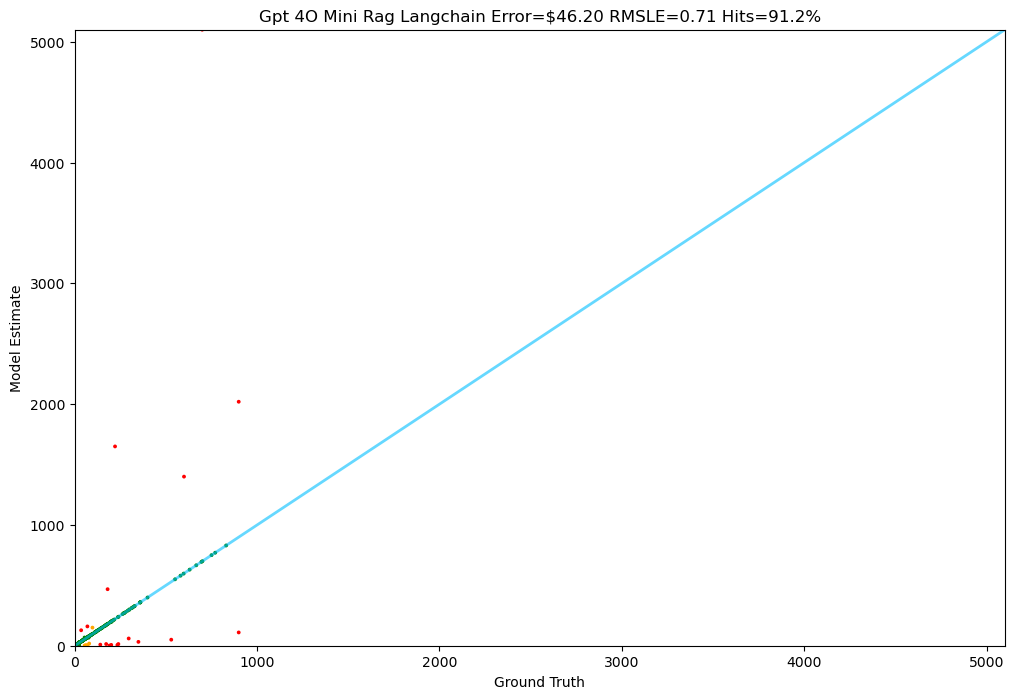

In [31]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.chains import ConversationalRetrievalChain
from langchain_openai import ChatOpenAI

def gpt_4o_mini_rag_langchain(item):
    template = """
    Role: You are a pricing assistant. You are given a question and some context. Answer the question based on the context.
    Input: "How much does this cost to the nearest dollar?
    Context: {context}
    Here is the question:{question}
    Answer:

    """
    # {context} is data derived from the database vectors that have similarities with the question
    # {question} is the question that will be asked to the application

    PROMPT = PromptTemplate(
        template = template,
        input_variables=["context", "question"]
    )
    llm = ChatOpenAI(temperature=0.0, model_name="gpt-4o-mini")
    qa_with_source = RetrievalQA.from_chain_type(
        llm = llm,
        chain_type = 'stuff',
        retriever = vector_store.as_retriever(search_kwargs={"k": 5}),
        chain_type_kwargs={"prompt":PROMPT,},
        return_source_documents=True,
    )
    product_price_stripped = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    rsp = qa_with_source.invoke("How much does this cost to the nearest dollar?\n\n" + product_price_stripped)

    '''
    {'query': 'How much does this cost to the nearest dollar?\n\nSony a5100 Mirrorless Digital Camera with 3-Inch Flip Up LCD (Black) (Renewed)\nSony a5100 Interchangeable Lens Camera with Lens, Black. Exposure Modes- AUTO (iAUTO, Superior Auto), Programmed AE (P), Aperture priority (A), Shutter-speed priority (S), Manual (M), Scene Selection, Sweep Panorama, Movie Ultra-fast auto focus with 179 AF points and 6Fps Capture life in high resolution with 24MP APS-C sensor.Lens compatibility Sony E-mount lenses Instant sharing via smartphone with Wi-Fi and NFC1 Record Full HD video3 up to 50MB/s Contains- Rechargeable Battery AC Charger Lens cap Shoulder strap Micro USB cable. BIONZ X engine for superb detail and noise reduction\n\nPrice is $699.00',
    'result': 'The cost is $699.',
    'source_documents': [Document(id='1b5fffc8-81b4-4beb-8652-fe3398aa2877', metadata={'price': 720.0}, page_content="Hitachi LCD Projector - 720p - HDTV - 4 3\nHitachi XGA 10000 1 Contrast Ratio - Overview Projector Hardware - LCD ProjectorSpecification From the classroom to the conference room, Hitachi's LCD projector combines superior image clarity, high quality value, and long-life reliability. Bright, vivid colors with razor-sharp text and bold graphics will truly enhance any lesson or mee XGA 10000 1 Contrast Ratio Projector Hardware - LCD Projector XGA 10000 1 Contrast Ratio Hitachi Manufacturer Hitachi, Part Weight 6.61 pounds, Dimensions 14.5 x 12.5 x 6.2 inches, model number Is Discontinued No, Wattage 210 watts, Quantity 1, Lumin"),
    Document(id='2ff754c1-ca8a-4daf-ab3c-5efdfd03478c', metadata={'price': 101.0}, page_content='Extech RH101 Combination Humidity Meter and Infrared Thermometer\nItem is a Class II laser product, 1mW power output. Combination humidity meter + IR thermometer features a large backlit dual display Primary display is user selectable for IR or humidity; Secondary displays ambient temperature IR thermometer offers non-contact temperature measurements from -58 to 932?F (-50 to 500?C) IR thermometer has built-in laser pointer and an 8 1 distance to target ratio Brand Extech, Age Range (Description) Adult, Included Components & Instructions Guide, Display Type Digital, Connectivity Technology Infrared, Care Instructions Wipe Clean, Power Source Battery Powered, Batteries 1 Lithium Ion batteries required. (included), Response Time 500 Milliseconds, Reusability Reusable'),
    Document(id='d8ed5510-1032-40ab-8bd9-0b6839117524', metadata={'price': 1.0}, page_content='BNP White Clock Temperature Humidity Digital Thermometer for Home HTC-1\nSpecifications Temperature range accuracy ±1°C resolution 0.1°C range RHHumidity accuracy ± 5% RHHumidity resolution 1% RHPower source 1*AAA (1.5V) batteryMaterial ABSColor White+BalckDimensions ( 4 3/16 H x 3 7/8 W x 7/8 Thick)Weight 153g Packaging & Delivery Blister box Carton size Gross weight Large character LCD display, easy to read Temperature, Humidity and Clock display simultaneously Hourly chime, Daily alarm function Calendar display function (Month and date) Max/Min temperature and humidity memory function Dimensions 5 x 6.5 x 1 inches, Weight'),
    Document(id='a28fba9a-29f1-4e67-b888-127331d0ef1a', metadata={'price': 98.0}, page_content="Nexia Z-Wave One Touch Control, Entirely Customizable White\nConveniently control the smart products in your home with the tap of a button! The Nexia One Touch provides quick access to the Nexia Automations and Modes that you assign to the device. No need to have your smart phone or computer near you at all times when you're enjoying the comforts of your home. Install the One Touch near your door to easily control your home when leaving or entering. Or, leave the One Touch on your coffee table or night stand for convenient access to your smart products at any time of the day or night. Simply tap a One Touch button to run any automation mode you've already set up in your Nexia account Home to turn on the lights, adjust the temperature and turn down"),
    Document(id='a03a5831-7c21-4ef2-925a-899439f1473e', metadata={'price': 436.0}, page_content='Ancona WPP436 36 Wall-Mounted Classic Pyramid Style Convertible Range Hood in Stainless Steel\nMade with high-quality 430 stainless steel, this Ancona range hood’s classic pyramid design adds sophistication and performance to your home at an affordable price. This range hood features easy-to-use electronic controls, eco-friendly LED lights, and easy-to-clean filters. This range hood is guaranteed to make a statement in any kitchen! wide; wall-mounted classic pyramid style 400 CFM - Independently tested, cETLus electronic controls, low speed 50-dBA 2 x LED lights – Designed by Ancona, powerful and bright, known to last up to 10 times longer than conventional lights Aluminum mesh filter; dishwasher safe; top 6-inch round ventilation, damper included;')]}
    '''
    return get_price(rsp['result'])

Tester.test(gpt_4o_mini_rag_langchain, test)

## Optional Extra: Trying a DeepSeek API call instead of OpenAI

If you have a DeepSeek API key, we will use it here as an alternative implementation; otherwise skip to the next section..

In [ ]:
# Connect to DeepSeek using the OpenAI client python library

deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key,base_url="https://api.deepseek.com")

In [ ]:
# Added some retry logic here because DeepSeek is very oversubscribed and sometimes fails..

def deepseek_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    while not done and retries > 0:
        try:
            response = deepseek_via_openai_client.chat.completions.create(
                model="deepseek-chat", 
                messages=messages_for(item, documents, prices),
                seed=42,
                max_tokens=8
            )
            reply = response.choices[0].message.content
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [ ]:
deepseek_api_rag(test[1])

In [ ]:
Tester.test(deepseek_api_rag, test)

## And now to wrap this in an "Agent" class

In [12]:
#from agents.frontier_agent import FrontierAgent
# from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.testing import Tester
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week8.agents.frontier_agent import FrontierAgent

In [13]:
# Let's print the logs so we can see what's going on

import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [14]:
agent = FrontierAgent(collection)

NameError: name 'collection' is not defined

In [53]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call gpt-4o-mini with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $139.99


139.99

In [56]:
#from agents.specialist_agent import SpecialistAgent
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week8.agents.specialist_agent import SpecialistAgent

In [57]:
agent2 = SpecialistAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal
/opt/conda/lib/python3.11/asyncio/events.py:80: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)


AuthError: Token missing. Could not authenticate client. If you have token credentials, see modal.com/docs/reference/modal.config for setup help. If you are a new user, register an account at modal.com, then run `modal token new`.

In [ ]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")